In [1]:
import pandas as pd
import numpy as np
import json
import requests
import warnings
warnings.filterwarnings("ignore")

In [2]:
#현황데이터 불러오기
trash_sum=pd.read_csv('데이터/trash_sum.csv',encoding='cp949') 

#취합데이터 불러오기
dataset=pd.read_csv('데이터/dataset.csv',encoding='cp949') 

#현황데이터와 취합데이터 merge
merge_dataset= pd.merge(left=trash_sum, right=dataset, how='outer', on='행정동')
merge_dataset=merge_dataset.fillna(0)
merge_dataset=merge_dataset.sort_values(by='행정동').reset_index(drop=True)
merge_dataset

,행정동,쓰레기통 수,총 생활인구 수,총 매출 건수,버스정류소 수,지하철역 수
0,가회동,13.0,14668149.0,11673960.0,23.0,0.0
1,교남동,2.0,1157553.0,5153420.0,24.0,0.0
2,무악동,0.0,737944.0,511342.0,4.0,0.0
3,부암동,0.0,18044324.0,3825932.0,36.0,0.0
4,사직동,42.0,10147192.0,8591112.0,40.0,2.0
5,삼청동,15.0,708366.0,2081240.0,16.0,1.0
6,숭인1동,1.0,1471257.0,167153.0,13.0,1.0
7,숭인2동,2.0,7907348.0,2546202.0,13.0,0.0
8,이화동,10.0,19447056.0,29944772.0,24.0,0.0
9,종로1.2.3.4가동,78.0,27171561.0,47291024.0,101.0,4.0


생활인구수, 매출, 버스정류소 수 많은데 쓰레기통 없는 경우 있음. 재분류 필요함.

In [3]:
# 변수간 pearson 상관분석
df=merge_dataset.iloc[:,2:]
corr=df.corr(method='pearson')
corr

,총 생활인구 수,총 매출 건수,버스정류소 수,지하철역 수
총 생활인구 수,1.000000,0.847087,0.589771,0.461570
총 매출 건수,0.847087,1.000000,0.609521,0.684154
버스정류소 수,0.589771,0.609521,1.000000,0.508011
지하철역 수,0.461570,0.684154,0.508011,1.000000


<Axes: >

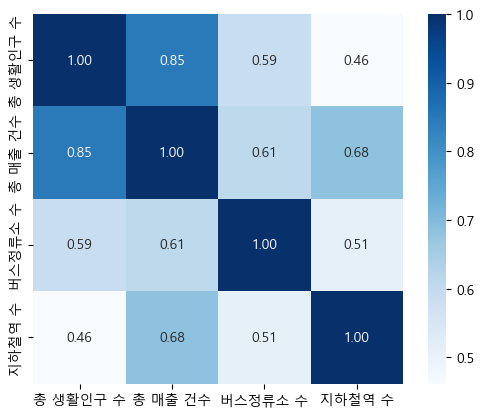

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'Malgun Gothic'
df_heatmap = sns.heatmap(corr, cbar = True, annot = True, annot_kws={'size' : 10}, 
                         fmt = '.2f', square = True, cmap = 'Blues')
df_heatmap

생활인구-매출 양의 상관관계

버스정류소보다 지하철역이 매출에 영향



1. 4가지 요인 활용해서 행정동별 쓰레기통 수 분류
2. 행정동별 버스정류소, 지하철역 좌표값 군집분석으로 쓰레기통 입지 선정

### 4가지 요인 취합하여 하나의 데이터셋으로 만들기

In [5]:
#데이터 불러오기
trash_map=pd.read_csv('데이터/trash_map.csv',encoding='cp949')
merge_pop_2021=pd.read_csv('데이터/merge_pop_2021.csv',encoding='cp949')
merge_sales=pd.read_csv('데이터/merge_sales.csv',encoding='cp949')
data_bus=pd.read_csv('데이터/data_bus.csv',encoding='cp949')
data_subway=pd.read_csv('데이터/data_subway.csv',encoding='cp949')

In [6]:
#분기별 생활 인구수-->연도별 총 생활인구수로 합산
sum_merge_pop=merge_pop_2021.groupby('엑스좌표_값')['총_생활인구_수'].sum().sort_values(ascending=False).to_frame().reset_index()

#연도별 생활인구수에 따라 좌표 표시
pop_2021= pd.merge(left=sum_merge_pop, right=merge_pop_2021, how='left', on='엑스좌표_값')
pop_2021=pop_2021.drop_duplicates('엑스좌표_값').reset_index()
pop_2021=pop_2021[['행정동','총_생활인구_수_x','엑스좌표_값','와이좌표_값']]

#행정동명만 추출
for i in range(len(pop_2021)): pop_2021['행정동'][i]=pop_2021['행정동'][i][4:]
pop_2021=pop_2021.rename(columns={'엑스좌표_값':'x좌표','와이좌표_값':'y좌표','총_생활인구_수_x':'총 생활인구 수'})

#좌표값 "epsg:5181" --> 'epsg:4326' 으로 변환
from pyproj import Proj, transform
epsg5179= Proj(init="epsg:5181")
wgs84=Proj(init='epsg:4326')
pop_2021['x좌표'], pop_2021['y좌표'] = transform(epsg5179, wgs84, pop_2021['x좌표'], pop_2021['y좌표'])
pop_2021=pop_2021.rename(columns={'y좌표':'x좌표','x좌표':'y좌표'})
pop_2021=pop_2021[['행정동','총 생활인구 수','x좌표','y좌표']]

In [7]:
#분기별 매출 건수-->연도별 총 매출 건수로 합산
sum_merge_sales=merge_sales.groupby('엑스좌표_값')['분기당_매출_건수'].sum().sort_values(ascending=False).to_frame().reset_index()

#연도별 매출건수에 따라 좌표 표시
sales_2021= pd.merge(left=sum_merge_sales, right=merge_sales, how='left', on='엑스좌표_값')
sales_2021=sales_2021.drop_duplicates('엑스좌표_값').reset_index()
sales_2021=sales_2021[['행정동','분기당_매출_건수_x','엑스좌표_값','와이좌표_값']]

#행정동명만 추출
for i in range(len(sales_2021)): sales_2021['행정동'][i]=sales_2021['행정동'][i][4:]
sales_2021=sales_2021.rename(columns={'엑스좌표_값':'x좌표','와이좌표_값':'y좌표','분기당_매출_건수_x':'총 매출 건수'})

#좌표값 "epsg:5181" --> 'epsg:4326' 으로 변환
from pyproj import Proj, transform
epsg5179= Proj(init="epsg:5181")
wgs84=Proj(init='epsg:4326')
sales_2021['x좌표'], sales_2021['y좌표'] = transform(epsg5179, wgs84, sales_2021['x좌표'], sales_2021['y좌표'])
sales_2021=sales_2021.rename(columns={'y좌표':'x좌표','x좌표':'y좌표'})
sales_2021=sales_2021[['행정동','총 매출 건수','x좌표','y좌표']]

In [8]:
#데이터를 합치기 위해 컬럼 형식  통일

pop_2021['종류']='생활인구 수'
pop_2021=pop_2021.rename(columns={'총 생활인구 수':'값'})
pop_2021=pop_2021[['행정동','x좌표','y좌표','종류','값']]

sales_2021['종류']='매출 건수'
sales_2021=sales_2021.rename(columns={'총 매출 건수':'값'})
sales_2021=sales_2021[['행정동','x좌표','y좌표','종류','값']]

data_bus['종류']='버스정류소'
data_bus=data_bus.rename(columns={'정류소명':'값'})
bus=data_bus[['행정동','x좌표','y좌표','종류','값']]

data_subway['종류']='지하철역'
data_subway=data_subway.rename(columns={'위도':'x좌표','경도':'y좌표','역명':'값'})
subway=data_subway[['행정동','x좌표','y좌표','종류','값']]

dataset=pd.concat([pop_2021,sales_2021,bus,subway],axis=0).reset_index(drop=True)

In [22]:
dataset

,행정동,x좌표,y좌표,종류,값
0,이화동,37.578728,127.001211,생활인구 수,14806927
1,부암동,37.597795,126.957208,생활인구 수,10835987
2,가회동,37.579745,126.985203,생활인구 수,8508460
3,종로1.2.3.4가동,37.571016,126.997849,생활인구 수,6776100
4,종로1.2.3.4가동,37.575701,126.991555,생활인구 수,6751659
...,...,...,...,...,...
632,충현동,37.565812,126.966639,지하철역,서대문
633,사직동,37.571665,126.976502,지하철역,광화문(세종문화회관)
634,종로1.2.3.4가동,37.572546,126.990447,지하철역,종로3가(탑골공원)
635,창신1동,37.572275,127.015666,지하철역,동묘앞


In [15]:
#쓰레기통 수 재배치를 위해 행정동별 비율계산하여 쓰레기통 수 재분류
# 전체 중에 차지하는 비율 * 기존 쓰레기통 수 (199)

dataset_count=dataset['행정동'].value_counts().to_frame().reset_index()

new_trash=[]
for i in range(len(dataset_count)):
    new_trash.append(round(199*(dataset_count['count'][i]/sum(dataset_count['count']))))
#new_trash

#new_trash 컬럼 추가
dataset_count['new_trash']=new_trash
#dataset_count

# 쓰레기통 수 재분류된 데이터 (197개로 재분류됨)
classification_dataset= pd.merge(left=dataset_count, right=trash_sum, how='outer', on='행정동')
classification_dataset=classification_dataset.rename(columns={'count':'재분류기준값'})
classification_dataset=classification_dataset[['행정동','쓰레기통 수','재분류기준값','new_trash']]
classification_dataset=classification_dataset.fillna(0)
classification_dataset

,행정동,쓰레기통 수,재분류기준값,new_trash
0,종로1.2.3.4가동,78.0,129,40
1,평창동,0.0,65,20
2,사직동,42.0,54,17
3,청운효자동,13.0,48,15
4,부암동,0.0,46,14
5,혜화동,8.0,45,14
6,종로5.6가동,6.0,44,14
7,이화동,10.0,32,10
8,가회동,13.0,29,9
9,교남동,2.0,26,8


In [16]:
#쓰레기통 수 재분류 시 생활인구수, 매출 비중을 고려하지 않은 점이 한계.. 

In [17]:
#재분류된 쓰레기통 수에 따라 행정동별로 clustering 하여 중심값에 쓰레기통 설치


In [18]:
# k-means 클러스터링 후 각 클러스터 별 중심값에 쓰레기통 설치

from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")

#행정동별 데이터셋 생성, 좌표값 불러오기
df=pd.DataFrame(columns=['행정동','클러스터번호','x좌표','y좌표']) # '최종 데이터프레임 생성'


for c in range(len(classification_dataset)):
    
    hang=classification_dataset.loc[c]['행정동']#행정동= 종로1.2.3.4동
    trash=classification_dataset.loc[c]['new_trash']#해당 행정동의 쓰레기통 수

    행정동=dataset[dataset['행정동']==hang].reset_index(drop=True)
    좌표=행정동[['x좌표','y좌표']]
    
    if trash !=0:

        #쓰레기통 재분류 수만큼 클러스터 생성
        kmeans = KMeans(n_clusters=trash, init="k-means++", max_iter=300, random_state=0)
        kmeans.fit(좌표)

        행정동['cluster'] = kmeans.labels_

        for t in range(trash):
            x=행정동[행정동['cluster']==t]['x좌표'].mean()
            y=행정동[행정동['cluster']==t]['y좌표'].mean()
            df.loc[len(df)]=[hang,t,x,y]

df

,행정동,클러스터번호,x좌표,y좌표
0,종로1.2.3.4가동,0,37.573428,126.976925
1,종로1.2.3.4가동,1,37.571013,126.991838
2,종로1.2.3.4가동,2,37.570932,126.987434
3,종로1.2.3.4가동,3,37.570266,126.999872
4,종로1.2.3.4가동,4,37.576173,126.997725
...,...,...,...,...
192,창신3동,1,37.581294,127.014093
193,창신제2동,0,37.574754,127.011371
194,숭인제1동,0,37.577249,127.016562
195,창신2동,0,37.572076,127.012087


In [19]:
# df_jongno=pd.DataFrame(columns=['행정동','클러스터번호','x좌표','y좌표']) # '최종 데이터프레임 생성'


# hang_jongro=classification_dataset.loc[0]['행정동']#행정동= 종로1.2.3.4동
# trash_jongno=classification_dataset.loc[0]['new_trash']#해당 행정동의 쓰레기통 수

# 행정동=dataset[dataset['행정동']==hang_jongro].reset_index(drop=True)
# 좌표=행정동[['x좌표','y좌표']]

# if trash !=0:

#     #쓰레기통 재분류 수만큼 클러스터 생성
#     kmeans = KMeans(n_clusters=trash_jongno, init="k-means++", max_iter=300, random_state=0)
#     kmeans.fit(좌표)

#     행정동['cluster'] = kmeans.labels_

#     for t in range(trash):
#         x=행정동[행정동['cluster']==t]['x좌표'].mean()
#         y=행정동[행정동['cluster']==t]['y좌표'].mean()
#         df_jongno.loc[len(df)]=[hang_jongro,t,x,y]
        
# df_jongno

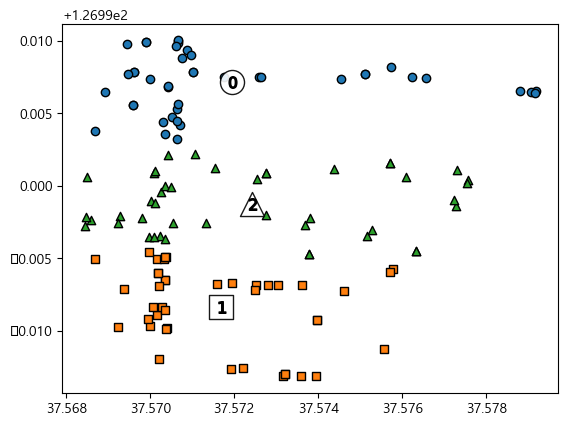

In [20]:
hang_jongro=classification_dataset.loc[0]['행정동']#행정동= 종로1.2.3.4동
trash_jongno=classification_dataset.loc[0]['new_trash']#해당 행정동의 쓰레기통 수

행정동=dataset[dataset['행정동']==hang_jongro].reset_index(drop=True)
좌표=행정동[['x좌표','y좌표']]


# K-Means 객체 생성
kmeans = KMeans(n_clusters=3, init="k-means++", max_iter=200, random_state=0)

# cluster label (fit 후 labels_, fit_predict의 결과가 같았다.)
cluster_labels = kmeans.fit_predict(좌표)
행정동["kmeans_label"] = cluster_labels

# 개별 클러스터의 중심 위치 좌표
centers = kmeans.cluster_centers_

# cluster 값 종류
unique_labels = np.unique(cluster_labels)
markers=['o', 's', '^', 'P','D','H','x']

for cluster in unique_labels:
    
    # 각 군집 시각화
    cluster_v = 행정동[행정동['kmeans_label'] == cluster]    
    plt.scatter(x=cluster_v['x좌표'], y=cluster_v['y좌표'], edgecolor='k', marker=markers[cluster] )
    
    # 군집별 중심 위치 시각화
    center_xy = centers[cluster]
    plt.scatter(x = center_xy[0], y = center_xy[1], s=300, color='white',
                alpha=0.9, edgecolor='k', marker = markers[cluster])
    plt.scatter(x = center_xy[0], y = center_xy[1], s=70, color='k', 
                edgecolor='k', marker = f"${cluster}$")
    
plt.show()

In [21]:
행정동

,행정동,x좌표,y좌표,종류,값,kmeans_label
0,종로1.2.3.4가동,37.571016,126.997849,생활인구 수,6776100,0
1,종로1.2.3.4가동,37.575701,126.991555,생활인구 수,6751659,2
2,종로1.2.3.4가동,37.570339,126.983496,생활인구 수,4338095,1
3,종로1.2.3.4가동,37.573790,126.985306,생활인구 수,3086040,2
4,종로1.2.3.4가동,37.573960,126.980733,생활인구 수,1541975,1
...,...,...,...,...,...,...
124,종로1.2.3.4가동,37.570624,126.999673,버스정류소,광장시장,0
125,종로1.2.3.4가동,37.570203,126.983116,지하철역,종각,1
126,종로1.2.3.4가동,37.570429,126.992095,지하철역,종로3가,2
127,종로1.2.3.4가동,37.571537,126.991237,지하철역,종로3가,2


In [13]:
df

,행정동,클러스터번호,x좌표,y좌표
0,종로1.2.3.4가동,0,37.573428,126.976925
1,종로1.2.3.4가동,1,37.571013,126.991838
2,종로1.2.3.4가동,2,37.570932,126.987434
3,종로1.2.3.4가동,3,37.570266,126.999872
4,종로1.2.3.4가동,4,37.576173,126.997725
...,...,...,...,...
192,창신3동,1,37.581294,127.014093
193,창신제2동,0,37.574754,127.011371
194,숭인제1동,0,37.577249,127.016562
195,창신2동,0,37.572076,127.012087


In [14]:
df['x좌표']

0      37.573428
1      37.571013
2      37.570932
3      37.570266
4      37.576173
         ...    
192    37.581294
193    37.574754
194    37.577249
195    37.572076
196    37.579358
Name: x좌표, Length: 197, dtype: float64

In [15]:
#최종 쓰레기통 입지 지도 시각화

import folium

#지도의 중심을 지정하기 위해 위도와 경도의 평균 구하기
lat= df['x좌표'].mean()
long= df['y좌표'].mean()

#위도 경도
df_x=df['x좌표']
df_y=df['y좌표']

#지도 띄우기
m = folium.Map([lat,long], zoom_start = 14)

coords = []
for i in range(len(df)-1):
    x = df_x[i]
    y = df_y[i]
    coords.append([x, y])
    
for i in range(len(coords)):
    folium.Circle(
        location = coords[i],
        radius = 50,
        color = '#000000',
        fill = 'crimson',
    ).add_to(m)

m

In [16]:
# 기존 쓰레기통 위치
trash_map=pd.read_csv('데이터/trash_map.csv',encoding='cp949')


# 설치현황 지도 시각화

#지도의 중심을 지정하기 위해 위도와 경도의 평균 구하기
lat= trash_map['x좌표'].mean()
long= trash_map['y좌표'].mean()

#위도 경도
trash_x=trash_map['x좌표']
trash_y=trash_map['y좌표']

#지도 띄우기
m = folium.Map([lat, long], zoom_start = 14)

coords = []
for i in range(len(trash_map)-1):
    x = trash_x[i]
    y = trash_y[i]
    coords.append([x, y])
    
for i in range(len(coords)):
    folium.Circle(
        location = coords[i],
        radius = 50,
        color = '#000000',
        fill = 'crimson',
    ).add_to(m)

m